In [32]:
import jax.numpy as np
from jax import grad, value_and_grad, jit, ops

import matplotlib.pyplot as plt
%matplotlib inline 

import SSN_classes
import SSN_power_spec
import gamma_SSN_losses as losses

from importlib import reload
reload(SSN_classes)
reload(SSN_power_spec)
reload(losses)

<module 'gamma_SSN_losses' from '/Users/cholt/Google Drive/Python/torch_SSN/jax_caleb/gamma_SSN_losses.py'>

In [33]:
#the constant (non-optimized) parameters:

#fixed point algorithm:
dt = 1
xtol = 1e-6
Tmax = 500

#power spectrum resolution and range
fnums = 30
freq_range = [15,100]

#SSN parameters
n = 2
k = 0.04
tauE = 20 # in ms
tauI = 10 # in ms
psi = 0.774

t_scale = 1
tau_s = np.array([4, 5, 100])*t_scale #in ms, AMPA, GABA, NMDA current decay time constants
NMDAratio = 0.4 #NMDA strength as a fraction of E synapse weight

In [34]:
def ssn_PS(params, contrasts):
    #unpack parameters
    Jee = params[0]
    Jei = params[1]
    Jie = params[2]
    Jii = params[3]
    i2e = params[4]
    
    cons = len(contrasts)

    J2x2 = np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * psi #np.array([[2.5, -1.3], [2.4,  -1.0]]) * np.pi * psi
    ssn = SSN_classes.SSN_2D_AMPAGABA(tau_s, NMDAratio, n,k,tauE,tauI, *np.abs(J2x2).ravel())
    
    r_init = np.zeros([ssn.N, len(contrasts)])
    inp_vec = np.array([[1], [i2e]]) * contrasts
    
    r_fp = ssn.fixed_point_r(inp_vec, r_init=r_init, Tmax=Tmax, dt=dt, xtol=xtol)
    
    spect, fs, _ = SSN_power_spec.linear_PS_sameTime(ssn, r_fp, SSN_power_spec.NoisePars(), freq_range, fnums, cons)
    
    return spect, fs, r_fp


#@jit
def loss(params):
    contrasts = np.array([0, 25, 50, 100])
    spect, fs, r_fp = ssn_PS(params, contrasts)
    
    if np.max(np.abs(np.imag(spect))) > 0.01:
        print("Spectrum is dangerously imaginary")
    
    spect_loss = losses.loss_spect_contrasts(fs, np.real(spect))
    rates_loss = losses.loss_rates_contrasts(r_fp)
    
    print(spect_loss/rates_loss)
    
    return spect_loss + rates_loss
#         return losses.loss_SSN_2D_contrast(fs, np.real(spect))
        
#         return losses.loss_SSN_2D_contrast(fs, np.real(spect))




# def ssn_PS_v(params, contrasts):
#     #unpack parameters
#     Jee = params[0]
#     Jei = params[1]
#     Jie = params[2]
#     Jii = params[3]
#     i2e = params[4]

#     J2x2 = np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * psi #np.array([[2.5, -1.3], [2.4,  -1.0]]) * np.pi * psi
#     ssn = SSN_classes.SSN_2D_AMPAGABA(tau_s, NMDAratio, n,k,tauE,tauI, *np.abs(J2x2).ravel())
    
#     spect = []
#     v_init = np.zeros(ssn.dim)
#     for con in contrasts:
#         inp_vec = np.array([1,i2e]) * con
#         v_fp = ssn.fixed_point(inp_vec, x_init=v_init, Tmax=Tmax, dt=dt, xtol=xtol)
#         v_init = v_fp
#         r_fp = ssn.powlaw( v_fp.reshape((ssn.num_rcpt, ssn.N)).sum(axis=0) )

#         powspecE, fs, _ = SSN_power_spec.linear_power_spect(ssn, r_fp, SSN_power_spec.NoisePars(), freq_range=freq_range, fnums=fnums)
#         spect.append(powspecE)
    
#     spect = np.array(spect).T
#     return spect, fs

      converged to fixed point at iter=207,      as max(abs(dx./max(xvec,1.0))) < 1e-06 
run time: 0.757166862487793


Text(0.5, 0, 'frequency (Hz)')

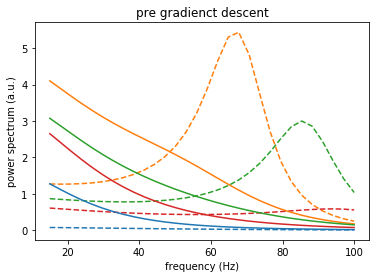

In [35]:
params_init = np.array([2.5, 1.3, 2.4,  1.0, 1.0]) # [Jee, Jei, Jie, Jii, i2e]
test_contrasts = np.array([0, 25, 50, 100])

import time
t0 = time.time()
spect, fs, r_fp = ssn_PS(params_init, test_contrasts)
tt = time.time()-t0
print("run time:", tt)

target_PS = losses.get_target_spect(fs)


fig, ax = plt.subplots(1,1)
ax.plot(fs, target_PS, "--")
ax.set_prop_cycle(None)
ax.plot(fs, spect/np.mean(spect))
ax.set_title('pre gradienct descent')
ax.set_ylabel('power spectrum (a.u.)')
ax.set_xlabel('frequency (Hz)')

# Run Gradient Descent

In [36]:
#dloss = grad(loss)
dloss = value_and_grad(loss)

gd_iters = 10
eta = .001 #learning rate

params = params_init
loss_t = []
t0 = time.time()
for ii in range(gd_iters):
    print("G.D. step ", ii+1)
    L, dL = dloss(params)
    params = params - eta * dL #dloss(params)
    loss_t.append(L)

print("{} GD steps took {} seconds.".format(gd_iters, time.time()-t0))
print("fit [Jee, Jei, Jie, Jii, i2e] = ", params)

G.D. step  1
      converged to fixed point at iter=207,      as max(abs(dx./max(xvec,1.0))) < 1e-06 
Traced<ConcreteArray(1314.3461)>with<JVPTrace(level=1/0)>
G.D. step  2
      converged to fixed point at iter=185,      as max(abs(dx./max(xvec,1.0))) < 1e-06 
Traced<ConcreteArray(1164.9135)>with<JVPTrace(level=1/0)>
G.D. step  3
      converged to fixed point at iter=162,      as max(abs(dx./max(xvec,1.0))) < 1e-06 
Traced<ConcreteArray(885.1106)>with<JVPTrace(level=1/0)>
G.D. step  4
      converged to fixed point at iter=146,      as max(abs(dx./max(xvec,1.0))) < 1e-06 
Traced<ConcreteArray(514.92194)>with<JVPTrace(level=1/0)>
G.D. step  5
      converged to fixed point at iter=128,      as max(abs(dx./max(xvec,1.0))) < 1e-06 
Traced<ConcreteArray(193.52126)>with<JVPTrace(level=1/0)>
G.D. step  6
      converged to fixed point at iter=113,      as max(abs(dx./max(xvec,1.0))) < 1e-06 
Traced<ConcreteArray(36.412262)>with<JVPTrace(level=1/0)>
G.D. step  7
      converged to fixed poi

      converged to fixed point at iter=105,      as max(abs(dx./max(xvec,1.0))) < 1e-06 


Text(0.5, 0, 'frequency (Hz)')

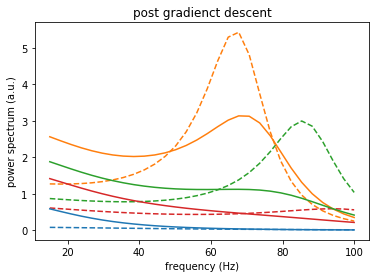

In [37]:
spect, fs, r_fp = ssn_PS(params, test_contrasts)
spect = spect/np.mean(spect)

fig, ax = plt.subplots(1,1)
ax.plot(fs, target_PS, "--")
#colrs = ax.get_color_cycle()
ax.set_prop_cycle(None)
ax.plot(fs, spect)
ax.set_title('post gradienct descent')
ax.set_ylabel('power spectrum (a.u.)')
ax.set_xlabel('frequency (Hz)')

In [38]:
print(losses.loss_rates_contrasts(r_fp))
print(losses.loss_spect_contrasts(fs, np.real(spect)))

0.148707
0.5059536


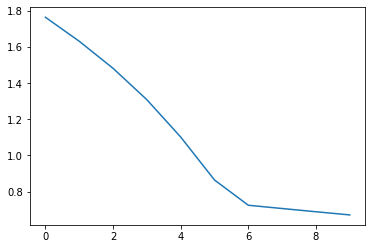

In [39]:
plt.plot(loss_t)

In [40]:
r_fp

DeviceArray([[ 0.      , 10.73217487, 11.78359318, 11.61781788],
             [ 0.      , 24.45079803, 34.49854279, 50.57500839]],
            dtype=float32)

In [49]:
2 + np.tanh((tar_r - r_fp - 20)/5) - np.tanh((tar_r - r_fp + 20)/5)

DeviceArray([[0.00134158, 0.01194084, 0.02535975, 0.06173474],
             [0.00134158, 0.10139549, 0.35651565, 0.99365723]],
            dtype=float32)